# How does PICA affect the (number of) urgent attack stages (AS) in the recommender matrix for different averaging percentages?

### Imports

In [81]:
import networkx as nx
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pygraphviz # Needs to be imported for some networkx functions
from enum import Enum
import math
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

### Mappings

In [82]:
class MicroAttackStage(Enum):
    INIT = 0

    TARGET_IDEN = 0.25
    SURFING = 0.25
    SOCIAL_ENGINEERING = 0.25
    HOST_DISC = 0.25
    SERVICE_DISC = 0.25
    VULN_DISC = 0.25
    INFO_DISC = 0.25

    USER_PRIV_ESC = 0.5
    ROOT_PRIV_ESC = 0.5
    NETWORK_SNIFFING = 0.5
    BRUTE_FORCE_CREDS = 0.5
    ACCT_MANIP = 0.5
    TRUSTED_ORG_EXP = 0.5
    PUBLIC_APP_EXP = 0.5
    REMOTE_SERVICE_EXP = 0.5
    SPEARPHISHING = 0.5
    SERVICE_SPECIFIC = 0.5
    DEFENSE_EVASION = 0.5
    COMMAND_AND_CONTROL = 0.5
    LATERAL_MOVEMENT = 0.5
    ARBITRARY_CODE_EXE = 0.5
    PRIV_ESC = 0.5

    END_POINT_DOS = 1
    NETWORK_DOS = 1
    SERVICE_STOP = 1
    RESOURCE_HIJACKING = 1
    DATA_DESTRUCTION = 1
    CONTENT_WIPE = 1
    DATA_ENCRYPTION = 1
    DEFACEMENT = 1
    DATA_MANIPULATION = 1
    DATA_EXFILTRATION = 1
    DATA_DELIVERY = 1
    PHISHING = 1

    NON_MALICIOUS = 0

class MicroAttackStageConfidentiality(Enum):
    INIT = 0.1

    # Low Severity
    TARGET_IDEN = 0.1
    SURFING = 0.1
    SOCIAL_ENGINEERING = 0.25
    HOST_DISC = 0.25
    SERVICE_DISC = 0.25
    VULN_DISC = 0.25
    INFO_DISC = 0.25

    # Medium Severity
    USER_PRIV_ESC = 0.5
    ROOT_PRIV_ESC = 0.5
    NETWORK_SNIFFING = 0.5
    BRUTE_FORCE_CREDS = 0.5
    ACCT_MANIP = 0.5
    TRUSTED_ORG_EXP = 0.5
    PUBLIC_APP_EXP = 0.5
    REMOTE_SERVICE_EXP = 0.5
    SPEARPHISHING = 0.5
    SERVICE_SPECIFIC = 0.5
    DEFENSE_EVASION = 0.1
    COMMAND_AND_CONTROL = 0.5
    LATERAL_MOVEMENT = 0.5
    ARBITRARY_CODE_EXE = 0.5
    PRIV_ESC = 0.5

    # High Severity
    END_POINT_DOS = 0.1
    NETWORK_DOS = 0.1
    SERVICE_STOP = 0.1
    RESOURCE_HIJACKING = 0.1
    DATA_DESTRUCTION = 0.1
    CONTENT_WIPE = 0.1
    DATA_ENCRYPTION = 0.1
    DEFACEMENT = 1
    DATA_MANIPULATION = 0.1
    DATA_EXFILTRATION = 1
    DATA_DELIVERY = 0.1
    PHISHING = 1


class MicroAttackStageAvailability(Enum):
    INIT = 0.1

    # Low Severity
    TARGET_IDEN = 0.1
    SURFING = 0.1
    SOCIAL_ENGINEERING = 0.1
    HOST_DISC = 0.1
    SERVICE_DISC = 0.1
    VULN_DISC = 0.1
    INFO_DISC = 0.1

    # Medium Severity
    USER_PRIV_ESC = 0.5
    ROOT_PRIV_ESC = 0.5
    NETWORK_SNIFFING = 0.1
    BRUTE_FORCE_CREDS = 0.5
    ACCT_MANIP = 0.5
    TRUSTED_ORG_EXP = 0.1
    PUBLIC_APP_EXP = 0.5
    REMOTE_SERVICE_EXP = 0.1
    SPEARPHISHING = 0.1
    SERVICE_SPECIFIC = 0.5
    DEFENSE_EVASION = 0.1
    COMMAND_AND_CONTROL = 0.1
    LATERAL_MOVEMENT = 0.1
    ARBITRARY_CODE_EXE = 0.1
    PRIV_ESC = 0.1

    # High Severity
    END_POINT_DOS = 1
    NETWORK_DOS = 1
    SERVICE_STOP = 1
    RESOURCE_HIJACKING = 1
    DATA_DESTRUCTION = 1
    CONTENT_WIPE = 1
    DATA_ENCRYPTION = 1
    DEFACEMENT = 0.1
    DATA_MANIPULATION = 0.1
    DATA_EXFILTRATION = 0.1
    DATA_DELIVERY = 0.1
    PHISHING = 0.1

    NON_MALICIOUS = 0.1


class MicroAttackStageIntegrity(Enum):
    INIT = 0.1

    # Low Severity
    TARGET_IDEN = 0.1
    SURFING = 0.1
    SOCIAL_ENGINEERING = 0.1
    HOST_DISC = 0.1
    SERVICE_DISC = 0.1
    VULN_DISC = 0.25
    INFO_DISC = 0.1

    # Medium Severity
    USER_PRIV_ESC = 0.1
    ROOT_PRIV_ESC = 0.5
    NETWORK_SNIFFING = 0.1
    BRUTE_FORCE_CREDS = 0.1
    ACCT_MANIP = 0.5
    TRUSTED_ORG_EXP = 0.5
    PUBLIC_APP_EXP = 0.5
    REMOTE_SERVICE_EXP = 0.5
    SPEARPHISHING = 0.1
    SERVICE_SPECIFIC = 0.5
    DEFENSE_EVASION = 0.1
    COMMAND_AND_CONTROL = 0.5
    LATERAL_MOVEMENT = 0.5
    ARBITRARY_CODE_EXE = 0.5
    PRIV_ESC = 0.1

    # High Severity
    END_POINT_DOS = 0.1
    NETWORK_DOS = 0.1
    SERVICE_STOP = 0.1
    RESOURCE_HIJACKING = 0.1
    DATA_DESTRUCTION = 1
    CONTENT_WIPE = 1
    DATA_ENCRYPTION = 1
    DEFACEMENT = 1
    DATA_MANIPULATION = 1
    DATA_EXFILTRATION = 0.1
    DATA_DELIVERY = 1
    PHISHING = 0.1

    NON_MALICIOUS = 0.1


# AIF Mapping
verbose_micro = {'INIT': 'INITILIZE',
'TARGET_IDEN': 'TARGET IDENTIFICATION',
'SURFING': 'SURFING',
'SOCIAL_ENGINEERING': 'SOCIAL ENGINEERING',
'HOST_DISC': 'HOST DISCOVERY',
'SERVICE_DISC': 'SERVICE DISCOVERY',
'VULN_DISC': 'VULNERABILTY DISCOVERY',
'INFO_DISC': 'INFO DISCOVERY',
'USER_PRIV_ESC': 'USER PRIVILEGE ESCALATION',
'ROOT_PRIV_ESC': 'ROOT PRIVILEGE ESCALATION',
'NETWORK_SNIFFING': 'NETWORK SNIFFING',
'BRUTE_FORCE_CREDS': 'BRUTE FORCE CREDENTIALS',
'ACCT_MANIP': 'ACCOUNT MANIPULATION',
'TRUSTED_ORG_EXP': 'TRUSTED ORG. EXPLOIT',
'PUBLIC_APP_EXP': 'PUBLIC APP EXPLOIT',
'REMOTE_SERVICE_EXP': 'REMOTE SERVICE EXPLOIT',
'SPEARPHISHING': 'SPEAR PHISHING',
'SERVICE_SPECIFIC': 'SERVICE SPECIFIC',
'DEFENSE_EVASION': 'DEFENSE EVASION',
'COMMAND_AND_CONTROL': 'COMMAND AND CONTROL',
'LATERAL_MOVEMENT': 'LATERAL MOVEMENT',
'ARBITRARY_CODE_EXE': 'ARBITRARY CODE EXECUTION',
'PRIV_ESC': 'PRIVILEGE ESCALATION',
'END_POINT_DOS': 'END POINT DoS',
'NETWORK_DOS': 'NETWORK DoS',
'SERVICE_STOP': 'SERVICE STOP',
'RESOURCE_HIJACKING': 'RESOURCE HIJACKING',
'DATA_DESTRUCTION': 'DATA DESTRUCTION',
'CONTENT_WIPE': 'CONTENT WIPE',
'DATA_ENCRYPTION': 'DATA ENCRYPTION',
'DEFACEMENT': 'DEFACEMENT',
'DATA_MANIPULATION': 'DATA MANIPULATION',
'DATA_EXFILTRATION': 'DATA EXFILTRATION',
'DATA_DELIVERY': 'DATA DELIVERY',
'PHISHING': 'PHISHING',
'NON_MALICIOUS': 'NOT MALICIOUS'}

inverted_mapping = {v: k for k,v in verbose_micro.items()}

### Helper Methods

In [96]:
def print_sorted_dic(dic):
    """
    Print the given dictionary (key, score) sorted on the score.
    """
    arr = sorted(dic.items(), key= lambda x : -x[1])
    for i,el in enumerate(arr):
        print(i+1,el)

def get_urgency_ais(urgency, level="HIGH"):
    res = []

    if level == "HIGH":
        for aif,urgence in urgency.items():
            if urgence > .5:
                res.append(aif)
        return res
    elif level == "MED":
        for aif,urgence in urgency.items():
            if .5 >= urgence > .25:
                res.append(aif)
        return res

    elif level == "LOW":
        for aif,urgence in urgency.items():
            if urgence <= .25:
                res.append(aif)

        return res
    else:
        raise Exception("Wrong level provided")

def get_attack_stage(node):
    index = 1 if "Victim" in node else 0
    
    name = node.split("\n")[index].replace('"',"").replace("\r","")
    name = inverted_mapping[name]
    return name


def make_heatmap(urgency, graph_name, metric_name, savefig=False):
    data_dict = urgency

    # Convert dictionary to DataFrame
    data = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Urgency'])
    data.reset_index(inplace=True)
    data.columns = ['Attack Stage', 'Urgency Score']
    data.set_index("Attack Stage", inplace=True)
    data = data.sort_values("Urgency Score", ascending=False)

    plt.figure()
    
    
    colors = [(0.99, 0.99, 0.59), (1.0, 0.7, 0.28), (0.76, 0.23, 0.13)]
    cmap = mcolors.ListedColormap(colors)

    # Define the color range and categories
    color_range = [0, 0.25, 0.5, 1]
    bounds = [0, 0.25, 0.5, 1] 
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    
    ax = sns.heatmap(data, cmap=cmap, linewidths=0.05, linecolor='white', annot=True, fmt=".3f", vmin=0, vmax=1, annot_kws={"size": 10}, norm=norm, cbar=False)
    cbar = plt.colorbar(ax.collections[0], ticks=[0,0.125,0.25, 0.375,0.5,0.75,1], boundaries=bounds, fraction=0.046, pad=0.04)
    cbar.set_ticklabels(["0", "Low", '0.25', "Medium", '0.5', "High", '1'])
    # Customize the plot
    plt.ylabel('Attack Stage')
    plt.title('Attack Stage Urgency Heatmap ' + graph_name + ' for ' + str(metric_name))
    # plt.title("Percentage: " +
    # Display the heatmap
    plt.tight_layout()
    if savefig == True:
        plt.savefig("./figs/rq1/" + str(graph_name) + "/heatmap" + graph_name + "_" + str(metric_name) + ".pdf")
    plt.show()

def get_as_occurences(graph):
    aif_count = dict()

    # Count AS occurences
    for node in graph.nodes:
        # Get attack stage and count
        name = get_attack_stage(node)
        aif_count[name] = aif_count.get(name, 0) + 1
    
    return aif_count

### Metrics

#### PICA

In [84]:
def get_pica_nodes(graph, w1, w2, w3):
    urgence = dict()
    max_in = 0

#     aif_count = dict()

#     for node in graph.nodes:
#         if "Victim" in node:
#             continue

#         name = get_attack_stage(node)
#         aif_count[name] = aif_count.get(name, 0) + 1

    for node in graph.nodes:
        if "Victim" in node: continue
        max_in = max(max_in, len(graph.in_edges(node)))

        non_verbose = get_attack_stage(node)

        urgence[node] = get_cia(non_verbose, w1, w2, w3)

    # Multiply by in-degree factor
    for node in graph.nodes:
        if "Victim" in node: continue
            
        if len(graph.in_edges(node)) == 0:
            urgence[node] = 1/max_in * urgence[node]
        else:
            urgence[node] = len(graph.in_edges(node))/max_in * urgence[node]


    # Normalise to [0,1]
    max_urgence = max(urgence.values())
    min_urgence = min(urgence.values())
    for node in graph.nodes:
        if "Victim" in node: continue
        urgence[node] = (urgence[node]-min_urgence)/(max_urgence-min_urgence)
#     print_sorted_dic(urgence)
    return urgence

def get_cia(ais, w1, w2, w3):
    confidentiality = MicroAttackStageConfidentiality.__getitem__(ais).value
    availability = MicroAttackStageAvailability.__getitem__(ais).value
    integrity = MicroAttackStageIntegrity.__getitem__(ais).value

#     if "DELIVERY" in ais:
#         print(confidentiality)
#         print(availability)
#         print(integrity)
    
    return (w1 * confidentiality + w2 * integrity + w3 * availability)/(w1+w2+w3)

def get_pica(graph, w1, w2, w3, percentage):
    return node_to_aif(get_pica_nodes(graph, w1, w2, w3), percentage)

def node_to_aif(urgence, percentage):
    aif_urgence = get_ais_nodes(urgence)

#     # For AS, create a list of urgencies from the belonging nodes
#     for node, urgency in urgence.items():
#         name = get_attack_stage(node)

#         if aif_urgence.get(name) is None:
#             aif_urgence[name] = [urgency]
#         else:
#             aif_urgence.get(name).append(urgency)

    aif_avg_urg = dict()

    # For each AS, take the average of the highest X percentage
    for aif,nodes in aif_urgence.items():
        if nodes is None:
            continue
        sorted_dict = sorted(nodes, reverse=True)

        # Determine the number of items to include in the top X% based on the dictionary size
        top_25_percent_count = math.ceil(len(sorted_dict) * percentage)

        top_25_percent_dict = sorted_dict[:top_25_percent_count]
        #
        aif_avg_urg[aif] = sum(top_25_percent_dict)/len(top_25_percent_dict)

    return aif_avg_urg

def get_ais_nodes(node_urgency):
    aif_urgency = dict()
    
    for node, urgency in node_urgency.items():
        name = get_attack_stage(node)

        if aif_urgency.get(name) is None:
            aif_urgency[name] = [urgency]
        else:
            aif_urgency.get(name).append(urgency)
    
    return aif_urgency

def execute_pica_percentages(graph, percentages):
    urgencies = []

    for percentage in percentages:
        urgencies.append(get_pica(graph, 1, 1, 1, percentage))

    return urgencies

#### Baseline

In [85]:
# Baseline Urgency Metric
def get_baseline(graph):
    """
    Calculate urgency for each attack stage in the graph.
    """
    aif_count = get_as_occurences(graph)

    urgence = dict()

    # Calculate urgency for each AS
    for k,v in aif_count.items():
        severity = MicroAttackStage.__getitem__(k).value

        # Severity * Prevalence
        urgence[k] =  severity * v/len(graph.nodes)

    # Normalise to scale to [0,1]
    max_urgence = max(urgence.values())
    min_urgence = min(urgence.values())
    for k,v in urgence.items():
        urgence[k] = (v-min_urgence)/(max_urgence-min_urgence)

    return urgence

def get_baseline_nodes(graph):
    """
    Get baseline urgency for node-level
    """
    # Get AS urgencies
    urgency = get_baseline(final)

    node_urgency = dict()

    # For each node assign same urgency as its attack stage
    for node in graph.nodes:
        attack_stage = get_attack_stage(node)
        node_urgency[node] = urgency[attack_stage]

    return node_urgency

### Graph Selection

In [163]:
gr_2018 = nx.nx_agraph.read_dot("./2018AGs/combined/combined-2018.dot")
gr_2017 = nx.nx_agraph.read_dot("./2017AGs/combined/combined-2017.dot")
linear = nx.nx_agraph.read_dot(r"C:\Users\senne\Documents\University\TU Delft CSE\Y3\Q4\Research Project\SAGE\2018AGs\2018.txt-attack-graph-for-victim-10.0.0.23-DATADELIVERYunknown.dot")

graphs = [gr_2017, gr_2018, linear]
graph_names = ["gr_2017", "gr_2018", "high_complex", "med_complex", "low_complex", "linear"]

In [164]:
final = gr_2017

In [165]:
print(len(final.nodes))

331


### Parameters

In [166]:
percentages = [0.01, 0.05,0.10, 0.15,0.25,0.33, 0.50, 0.75,1]

### Quantitative

In [167]:
# Calculate PICA AIS urgency per percentage
pica_urgencies = execute_pica_percentages(final, percentages)

pica_node_urgency = get_pica_nodes(final, 1, 1, 1)

base_urgency = get_baseline(final)

In [168]:
# Print number of high/med/low urgency ais for PICA
for percentage, urgency in zip(percentages, pica_urgencies):
    print(percentage)
    for val in ["HIGH", "MED", "LOW"]:
        print(val)
        print(len(get_urgency_ais(urgency, val)), get_urgency_ais(urgency, val))
#     percentage_nr_hi.append(len(get_urgency_ais(urgency, "HIGH")))
#     percentage_nr_me.append(len(get_urgency_ais(urgency, "MED")))
#     percentage_nr_lo.append(len(get_urgency_ais(urgency, "LOW")))
    print()

0.01
HIGH
8 ['ARBITRARY_CODE_EXE', 'HOST_DISC', 'SERVICE_DISC', 'VULN_DISC', 'COMMAND_AND_CONTROL', 'DATA_EXFILTRATION', 'NETWORK_DOS', 'ACCT_MANIP']
MED
4 ['DATA_DELIVERY', 'INFO_DISC', 'REMOTE_SERVICE_EXP', 'SURFING']
LOW
7 ['USER_PRIV_ESC', 'BRUTE_FORCE_CREDS', 'ROOT_PRIV_ESC', 'PRIV_ESC', 'PUBLIC_APP_EXP', 'DATA_MANIPULATION', 'DEFENSE_EVASION']

0.05
HIGH
8 ['ARBITRARY_CODE_EXE', 'HOST_DISC', 'SERVICE_DISC', 'VULN_DISC', 'COMMAND_AND_CONTROL', 'DATA_EXFILTRATION', 'NETWORK_DOS', 'ACCT_MANIP']
MED
4 ['DATA_DELIVERY', 'INFO_DISC', 'REMOTE_SERVICE_EXP', 'SURFING']
LOW
7 ['USER_PRIV_ESC', 'BRUTE_FORCE_CREDS', 'ROOT_PRIV_ESC', 'PRIV_ESC', 'PUBLIC_APP_EXP', 'DATA_MANIPULATION', 'DEFENSE_EVASION']

0.1
HIGH
6 ['ARBITRARY_CODE_EXE', 'HOST_DISC', 'VULN_DISC', 'COMMAND_AND_CONTROL', 'DATA_EXFILTRATION', 'NETWORK_DOS']
MED
6 ['DATA_DELIVERY', 'SERVICE_DISC', 'INFO_DISC', 'REMOTE_SERVICE_EXP', 'ACCT_MANIP', 'SURFING']
LOW
7 ['USER_PRIV_ESC', 'BRUTE_FORCE_CREDS', 'ROOT_PRIV_ESC', 'PRIV_ESC', '

In [169]:
# Print number of high/med/low urgency AIS for baseline
base_high = get_urgency_ais(base_urgency, "HIGH")
base_med = get_urgency_ais(base_urgency, "MED")
base_low = get_urgency_ais(base_urgency, "LOW")

print(len(base_high), base_high)
print(len(base_med), base_med)
print(len(base_low), base_low)

2 ['DATA_DELIVERY', 'DATA_EXFILTRATION']
1 ['NETWORK_DOS']
16 ['ARBITRARY_CODE_EXE', 'HOST_DISC', 'SERVICE_DISC', 'VULN_DISC', 'COMMAND_AND_CONTROL', 'INFO_DISC', 'USER_PRIV_ESC', 'REMOTE_SERVICE_EXP', 'ACCT_MANIP', 'SURFING', 'BRUTE_FORCE_CREDS', 'ROOT_PRIV_ESC', 'PRIV_ESC', 'PUBLIC_APP_EXP', 'DATA_MANIPULATION', 'DEFENSE_EVASION']


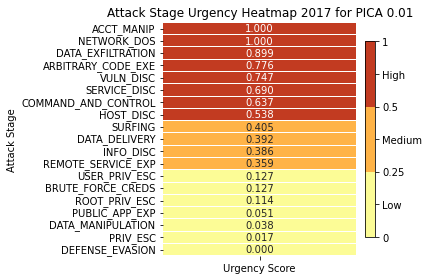

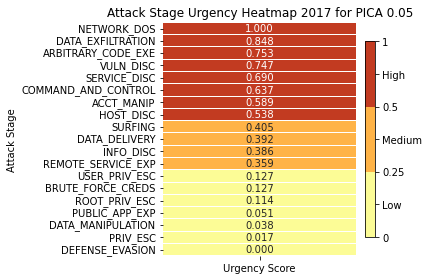

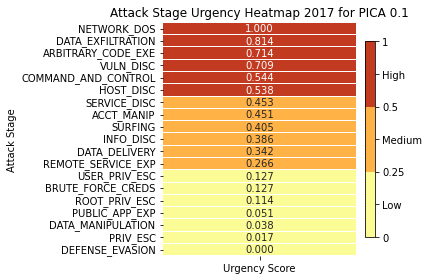

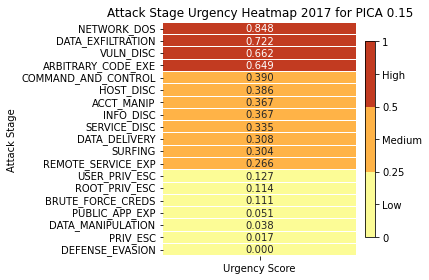

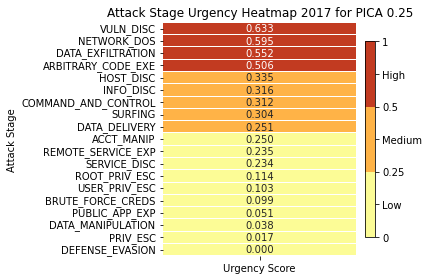

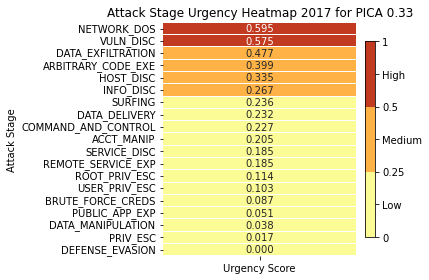

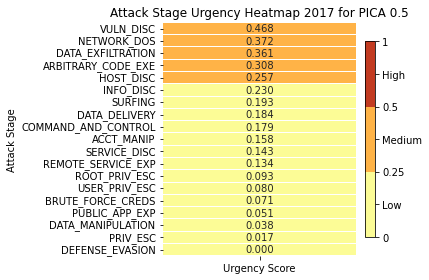

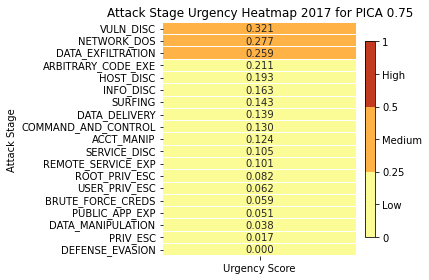

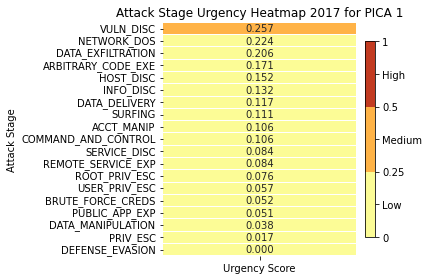

<Figure size 432x288 with 0 Axes>

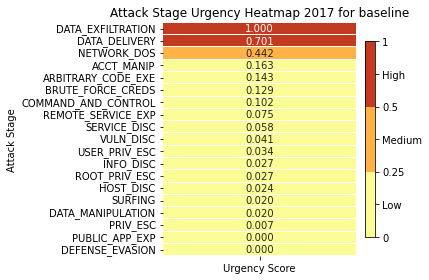

In [170]:
# Show heatmap for all percentages and for baseline
for percentage, urgency in zip(percentages, pica_urgencies):
    make_heatmap(urgency, "2017",  "PICA " + str (percentage), True)
plt.figure()
make_heatmap(base_urgency, "2017", "baseline", False)

<Figure size 432x288 with 0 Axes>

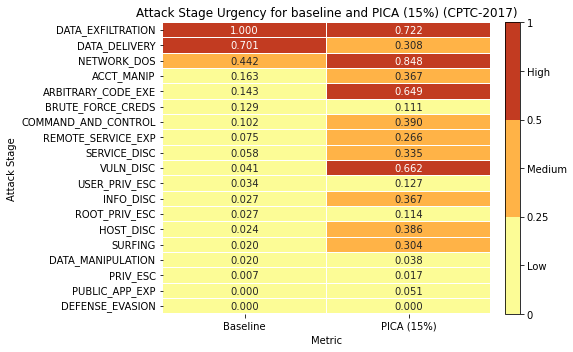

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [162]:
plt.figure()
plt.figure(figsize=(8, 5))

df = pd.DataFrame([base_urgency, get_pica(final, 1, 1, 1, 0.15)])

df = df.set_index(pd.Series(["Baseline", "PICA (15%)"]))
df.index.name = "Metric"


sorted_columns = df.loc['Baseline'].sort_values(ascending=False).index
df = df[sorted_columns]

df = df.transpose()


colors = [(0.99, 0.99, 0.59), (1.0, 0.7, 0.28), (0.76, 0.23, 0.13)]
cmap = mcolors.ListedColormap(colors)

# Define the color range and categories
color_range = [0, 0.25, 0.5, 1]
bounds = [0, 0.25, 0.5, 1] 
norm = mcolors.BoundaryNorm(bounds, cmap.N)



ax = sns.heatmap(df, cmap=cmap, annot=True, linewidths=0.05, linecolor='white', fmt='.3f', vmin=0, vmax=1, annot_kws={"size": 10}, norm=norm, cbar=False)
cbar = plt.colorbar(ax.collections[0], ticks=[0,0.125,0.25, 0.375,0.5,0.75,1], boundaries=bounds, fraction=0.046, pad=0.04)
cbar.set_ticklabels(["0", "Low", '0.25', "Medium", '0.5', "High", '1'])
# ax = sns.heatmap(df, annot=True, cmap="YlGnBu", linewidths=0.5, linecolor='white', fmt='.1f', annot_kws={"size": 10})

# Rotate the y-axis tick labels horizontally
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
ax.set_ylabel("Attack Stage")
plt.title('Attack Stage Urgency for baseline and PICA (15%) (CPTC-2017)')
plt.tight_layout()
plt.savefig("./figs/rq1/heatmap_comparing_2017.pdf")
plt.show()  # Display the plot
plt.figure()

### Qualititative

#### Baseline

Look at prevalence/severity per AS in the different urgency categories

In [171]:
def print_baseline_characteristics(graph, ais):
    as_count = get_as_occurences(graph)
    as_prevalence = {k: v/len(graph.nodes) for k,v in as_count.items()}
    ais_prevalence_severity = dict()
    
    
    for k in ais:
        ais_prevalence_severity[k] = (as_prevalence[k], MicroAttackStage.__getitem__(k).value, as_count[k])
    
    print("(prevalence, severity)")
    print("#nodes:", len(graph.nodes))
    print("Max nodes per AS:", max(as_count.values()))
    print("Max prevalence:", max(as_prevalence.values()))
    print(ais_prevalence_severity)

In [172]:
print_baseline_characteristics(final, base_high)

(prevalence, severity)
#nodes: 331
Max nodes per AS: 74
Max prevalence: 0.22356495468277945
{'DATA_DELIVERY': (0.15709969788519637, 1, 52), 'DATA_EXFILTRATION': (0.22356495468277945, 1, 74)}


In [173]:
print_baseline_characteristics(final, base_med)

(prevalence, severity)
#nodes: 331
Max nodes per AS: 74
Max prevalence: 0.22356495468277945
{'NETWORK_DOS': (0.09969788519637462, 1, 33)}


In [174]:
print_baseline_characteristics(final, base_low)

(prevalence, severity)
#nodes: 331
Max nodes per AS: 74
Max prevalence: 0.22356495468277945
{'ARBITRARY_CODE_EXE': (0.06646525679758308, 0.5, 22), 'HOST_DISC': (0.027190332326283987, 0.25, 9), 'SERVICE_DISC': (0.05740181268882175, 0.25, 19), 'VULN_DISC': (0.04229607250755287, 0.25, 14), 'COMMAND_AND_CONTROL': (0.04833836858006042, 0.5, 16), 'INFO_DISC': (0.030211480362537766, 0.25, 10), 'USER_PRIV_ESC': (0.01812688821752266, 0.5, 6), 'REMOTE_SERVICE_EXP': (0.03625377643504532, 0.5, 12), 'ACCT_MANIP': (0.0755287009063444, 0.5, 25), 'SURFING': (0.02416918429003021, 0.25, 8), 'BRUTE_FORCE_CREDS': (0.06042296072507553, 0.5, 20), 'ROOT_PRIV_ESC': (0.015105740181268883, 0.5, 5), 'PRIV_ESC': (0.006042296072507553, 0.5, 2), 'PUBLIC_APP_EXP': (0.0030211480362537764, 0.5, 1), 'DATA_MANIPULATION': (0.006042296072507553, 1, 2), 'DEFENSE_EVASION': (0.0030211480362537764, 0.5, 1)}


#### PICA

Look at the paths, used nodes and their CIA value (for 5, 10 and 15%)

In [175]:
def print_pica_characteristics(graph, ais, percentage, node_urgency):
    
    max_in = 0
    as_paths = dict()

#     for node in graph.nodes:
#         if "Victim" in node:
#             continue

#         max_in = max(max_in, len(graph.in_edges(node)))

#         non_verbose = get_attack_stage(node)

#         urgence[node] = get_cia(non_verbose, w1, w2, w3)
    
    
    # Multiply by in-degree factor
    for node in graph.nodes:
#         if "Victim" in node:
#             continue
        
        max_in = max(max_in, len(graph.in_edges(node)))
        
        if len(graph.in_edges(node)) == 0:
            as_paths[node] = 0
        else:
            as_paths[node] = len(graph.in_edges(node))
    
    print("Max in_deg of graph:", max_in)
    print("------------- ais " + str(ais) + " for percentage " + str(percentage) + "----------------")
    print("CIA score:", get_cia(ais, 1, 1, 1))
    
    values = []
    
    for node, urgency in node_urgency.items():
        
        name = get_attack_stage(node)

        if ais != name:
            continue
        values.append((node, urgency, as_paths[node]))
        
    # For each AS, take the average of the highest X percentage
#     for aif,nodes in aif_urgency.items():

#         sorted_dict = sorted(nodes, reverse=True)

    sorted_dict = sorted(values, key=lambda x: x[1], reverse=True)

    # nodes
#         print(sorted_dict)

    # Determine the number of items to include in the top X% based on the dictionary size
    top_25_percent_count = math.ceil(len(sorted_dict) * percentage)

    print("Number of used nodes:", top_25_percent_count)
    print("Out of:", len(sorted_dict))
    # top x% nodes
    top_25_percent_dict = sorted_dict[:top_25_percent_count]
    #

#         print(top_25_percent_count)
#         print(aif)
#         print(ais_nodes[aif])
#         aif_avg_urg[aif] = sum(top_25_percent_dict)/len(top_25_percent_dict)
    print("Used nodes (node, urgency, paths):\n", top_25_percent_dict )
#         ais_nodes_cia_paths[aif] = (ais_nodes(aif), get_cia(k, 1, 1, 1) ,as_paths[k])
#     for k,v in ais:
    
    print("-----------------------------------------------------------\n\n\n")
#     return ais_prevalence_nodes

In [176]:
analysed_percentages = [.15]

In [177]:
# High
for percentage in analysed_percentages:
    ais_list = get_urgency_ais(pica_urgencies[percentages.index(percentage)], level="HIGH")
    
    for ais in ais_list:
        print_pica_characteristics(final, ais, percentage, pica_node_urgency)
        

Max in_deg of graph: 37
------------- ais ARBITRARY_CODE_EXE for percentage 0.15----------------
CIA score: 0.3666666666666667
Number of used nodes: 4
Out of: 22
Used nodes (node, urgency, paths):
 [('ARBITRARY CODE EXECUTION\nssdp | ID: 355', 0.7763713080168777, 17), ('ARBITRARY CODE EXECUTION\nhttp | ID: 32', 0.7299578059071731, 16), ('ARBITRARY CODE EXECUTION\nmicrosoft-ds | ID: 309', 0.6371308016877638, 14), ('ARBITRARY CODE EXECUTION\nunknown | ID: 47', 0.4514767932489452, 10)]
-----------------------------------------------------------



Max in_deg of graph: 37
------------- ais VULN_DISC for percentage 0.15----------------
CIA score: 0.19999999999999998
Number of used nodes: 3
Out of: 14
Used nodes (node, urgency, paths):
 [('VULNERABILTY DISCOVERY\nms-sql-s', 0.7468354430379747, 30), ('VULNERABILTY DISCOVERY\nncube-lm', 0.670886075949367, 27), ('VULNERABILTY DISCOVERY\npostgresql', 0.5696202531645568, 23)]
-----------------------------------------------------------



Max in_d

In [178]:
# Med
for percentage in analysed_percentages:
    ais_list = get_urgency_ais(pica_urgencies[percentages.index(percentage)], level="MED")
    
    for ais in ais_list:
        print_pica_characteristics(final, ais, percentage, pica_node_urgency)

Max in_deg of graph: 37
------------- ais DATA_DELIVERY for percentage 0.15----------------
CIA score: 0.4000000000000001
Number of used nodes: 3
Out of: 18
Used nodes (node, urgency, paths):
 [('DATA DELIVERY\nhttp | ID: 246', 0.3924050632911393, 8), ('DATA DELIVERY\nhttp | ID: 21', 0.29113924050632917, 6), ('DATA DELIVERY\nvrml-multi-use | ID: 416', 0.2405063291139241, 5)]
-----------------------------------------------------------



Max in_deg of graph: 37
------------- ais HOST_DISC for percentage 0.15----------------
CIA score: 0.15
Number of used nodes: 2
Out of: 9
Used nodes (node, urgency, paths):
 [('HOST DISCOVERY\nhttp', 0.5379746835443038, 29), ('HOST DISCOVERY\nms-wbt-server', 0.23417721518987342, 13)]
-----------------------------------------------------------



Max in_deg of graph: 37
------------- ais SERVICE_DISC for percentage 0.15----------------
CIA score: 0.15
Number of used nodes: 3
Out of: 19
Used nodes (node, urgency, paths):
 [('SERVICE DISCOVERY\nunknown', 0

In [179]:
# Low
for percentage in analysed_percentages:
    ais_list = get_urgency_ais(pica_urgencies[percentages.index(percentage)], level="LOW")
    
    for ais in ais_list:
        print_pica_characteristics(final, ais, percentage, pica_node_urgency)

Max in_deg of graph: 37
------------- ais USER_PRIV_ESC for percentage 0.15----------------
CIA score: 0.3666666666666667
Number of used nodes: 1
Out of: 6
Used nodes (node, urgency, paths):
 [('USER PRIVILEGE ESCALATION\nhttp | ID: 49', 0.12658227848101267, 3)]
-----------------------------------------------------------



Max in_deg of graph: 37
------------- ais BRUTE_FORCE_CREDS for percentage 0.15----------------
CIA score: 0.3666666666666667
Number of used nodes: 3
Out of: 20
Used nodes (node, urgency, paths):
 [('BRUTE FORCE CREDENTIALS\nunknown | ID: 1', 0.12658227848101267, 3), ('BRUTE FORCE CREDENTIALS\nwebsm | ID: 66', 0.12658227848101267, 3), ('BRUTE FORCE CREDENTIALS\npop3s | ID: 886', 0.08016877637130802, 2)]
-----------------------------------------------------------



Max in_deg of graph: 37
------------- ais ROOT_PRIV_ESC for percentage 0.15----------------
CIA score: 0.5
Number of used nodes: 1
Out of: 5
Used nodes (node, urgency, paths):
 [('ROOT PRIVILEGE ESCALATIO

Load graph stats 

In [180]:
# 2017 stats
print("------2017-------")
print("Total nodes:", len(gr_2017.nodes))
ais_count = dict()
for node in gr_2017.nodes:
    if "Victim" in node: continue
    ais = get_attack_stage(node)
    ais_count[ais] = ais_count.get(ais, 0) + 1
print("Max nodes per AS:", max(ais_count.values()))

print("--AS Node count--")
for k,v in ais_count.items():
    print(str(k) + ": " + str(v))
    
print(sum(ais_count.values()))

------2017-------
Total nodes: 331
Max nodes per AS: 25
--AS Node count--
DATA_DELIVERY: 18
ARBITRARY_CODE_EXE: 22
HOST_DISC: 9
SERVICE_DISC: 19
VULN_DISC: 14
COMMAND_AND_CONTROL: 16
INFO_DISC: 10
USER_PRIV_ESC: 6
DATA_EXFILTRATION: 25
REMOTE_SERVICE_EXP: 12
NETWORK_DOS: 9
ACCT_MANIP: 25
SURFING: 8
BRUTE_FORCE_CREDS: 20
ROOT_PRIV_ESC: 5
PRIV_ESC: 2
PUBLIC_APP_EXP: 1
DATA_MANIPULATION: 1
DEFENSE_EVASION: 1
223


In [51]:
# 2018 stats
print("------2018-------")
print("Total nodes:", len(gr_2018.nodes))
ais_count = dict()
for node in gr_2018.nodes:
    if "Victim" in node: continue
    ais = get_attack_stage(node)
    ais_count[ais] = ais_count.get(ais, 0) + 1
print("Max nodes per AS:", max(ais_count.values()))

print("--AS Node count--")
for k,v in ais_count.items():
    print(str(k) + ": " + str(v) + ", " + str(v/len(gr_2018.nodes)))
    
print("--AS Node in-degree--")
for k,v in ais_count.items():
    print(str(k) + ": " + str(v) + ", " + str(v/len(gr_2018.nodes)))

------2018-------
Total nodes: 247
Max nodes per AS: 19
--AS Node count--
DATA_DELIVERY: 8, 0.032388663967611336
VULN_DISC: 13, 0.05263157894736842
SERVICE_DISC: 14, 0.05668016194331984
INFO_DISC: 10, 0.04048582995951417
ARBITRARY_CODE_EXE: 13, 0.05263157894736842
DATA_MANIPULATION: 11, 0.044534412955465584
HOST_DISC: 7, 0.02834008097165992
DATA_EXFILTRATION: 11, 0.044534412955465584
NETWORK_DOS: 4, 0.016194331983805668
REMOTE_SERVICE_EXP: 15, 0.06072874493927125
SURFING: 8, 0.032388663967611336
ROOT_PRIV_ESC: 19, 0.07692307692307693
ACCT_MANIP: 13, 0.05263157894736842
COMMAND_AND_CONTROL: 1, 0.004048582995951417
BRUTE_FORCE_CREDS: 3, 0.012145748987854251
RESOURCE_HIJACKING: 12, 0.048582995951417005
USER_PRIV_ESC: 5, 0.020242914979757085
DATA_DESTRUCTION: 1, 0.004048582995951417
PUBLIC_APP_EXP: 2, 0.008097165991902834
TRUSTED_ORG_EXP: 2, 0.008097165991902834
--AS Node in-degree--
DATA_DELIVERY: 8, 0.032388663967611336
VULN_DISC: 13, 0.05263157894736842
SERVICE_DISC: 14, 0.0566801619433